# DRAC 2022
在本project中, 我们将进行DRAC2022 Task3的相关探索

以下将列出所需的包(安装)
```
pip install vimm or pretrainedmodels
```

# 环境配置
确保同目录下有requirements.txt文件, 之后运行如下代码

In [85]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
ERROR: Could not find a version that satisfies the requirement torch==1.10.0+cu113 (from versions: 1.4.0, 1.5.0, 1.5.1, 1.6.0, 1.7.0, 1.7.1, 1.8.0, 1.8.1, 1.9.0, 1.9.1, 1.10.0, 1.10.1, 1.10.2, 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1)
ERROR: No matching distribution found for torch==1.10.0+cu113

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip


In [86]:
from timm.models.vision_transformer import VisionTransformer, _cfg
from timm.models.registry import register_model
from timm.models.layers import trunc_normal_
from c_dataload import OCTA_DATA,train_one_epoch, evaluate
from torch.utils.data import DataLoader
from PIL import Image
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
import math

In [87]:
# 一些超参数
batch_size=8
Num_worker=8
Lr=1e-3
Epochs=15
Device=0
Lrf=0.01

# 一些路径信息
writer_path='/root/tf-logs/'
import os
path ='./'
name='model.pth'
dirs = os.listdir( path )
new=0.0
for f in dirs:
    if os.path.splitext(f)[1] == '.pth':   # 只读取固定后缀的文件
        new=max(float(f[6:-4]),new)
best_acc=new

0.8285714285714286


# Dataloader

在这个部分, 我们将会从给定的数据集中读取相关数据

OCTA_DATA 参数如下
- dataset_path: 数据的直接路径, 只有图片的那个文件夹
- csv_path=None: 仅有val和train需要, 直接为csv文件的路径
- type=0: 0-train 1-val 2-test
- val_prob=0.3: val在总training数据的占比

我们使用正负数的方式来表示这个数据属于train还是val, 因此运行完dataload, csv文件可能看起来有点奇怪()
每次train/val的数据划分在train中实现, 因此请保证先创建train的数据, 而后val

DA操作在OCTA_DATA的魔法方法中实现, 可从c_dataload.py-OCTA_DATA中获得详细内容 


In [88]:

# 将这个改成对应的数据集路径即可
dataset_path='/root/autodl-tmp/back_up_for_main/4i/C. Diabetic Retinopathy Grading'

test_path=dataset_path+'/1. Original Images/b. Testing Set/'
train_path=dataset_path+'/1. Original Images/a. Training Set/'
ground_path=dataset_path+'/2. Groundtruths/a. DRAC2022_ Diabetic Retinopathy Grading_Training Labels.csv'

train_dataset=OCTA_DATA(train_path,ground_path,0)
val_dataset=OCTA_DATA(train_path,ground_path,1)
test_dataset=OCTA_DATA(test_path,None,2)

print("Length of test/train/val dataset",len(test_dataset),len(train_dataset),len(val_dataset))

train_loader = DataLoader(train_dataset,  shuffle=True, batch_size=batch_size, num_workers=Num_worker, pin_memory=True)
val_loader = DataLoader(val_dataset, shuffle=True, batch_size=batch_size, num_workers=Num_worker, pin_memory=True)
test_loader=DataLoader(test_dataset,shuffle=False,batch_size=batch_size,num_workers=Num_worker)

Starting to load data for dataset_path: /root/autodl-tmp/back_up_for_main/4i/C. Diabetic Retinopathy Grading/1. Original Images/b. Testing Set/
Starting to load data for dataset_path: /root/autodl-tmp/back_up_for_main/4i/C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set/
3
Starting to load data for dataset_path: /root/autodl-tmp/back_up_for_main/4i/C. Diabetic Retinopathy Grading/1. Original Images/a. Training Set/
3
Length of test/train/val dataset 386 442 169


# 主模型

In [ ]:
import torch
import pretrainedmodels
import pretrainedmodels.utils as utils
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

device = torch.device(Device if torch.cuda.is_available() else "cpu")

#resnet18 
model_name = 'resnet18' # could be fbresnet152 or inceptionresnetv2
model = pretrainedmodels.__dict__[model_name](num_classes=1000, pretrained='imagenet')
model.last_linear= torch.nn.Linear(model.last_linear.in_features, 3)
model=model.to(device)

# 如果用vimm的resnet18
# import timm
# import torchvision
# from timm.models.vision_transformer import vit_base_patch16_224_in21k as create_model  
# 从timm库导入模型
# resnet18 
# model = timm.create_model("resnet18",num_classes=3, pretrained=True).to(device)

tb_writer = SummaryWriter(log_dir=writer_path)
optimizer = optim.SGD(model.parameters(), lr=Lr, momentum=0.9, weight_decay=1e-5)
lf = lambda x: ((1 + math.cos(x * math.pi / Epochs)) / 2) * (1 - Lrf) + Lrf # cosine learning rate decay
scheduler = lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)  # cosine learning rate decay


In [90]:

import numpy as np
from sklearn.metrics import roc_auc_score
# import os
# path ='./'
# dirs = os.listdir( path )
# file='model.pth'
# new=0.0
# for f in dirs:
#     if os.path.splitext(f)[1] == '.pth':   # 只读取固定后缀的文件
#         new=max(float(f[6:-4]),new)
# print(new)
# if new-0>1e-2:
#     file='model-'+str(new)+'.pth'
# if file!='model.pth':
#     model.load_state_dict(torch.load(file))
    
def confusion_matrix(rater_a, rater_b, min_rating=None, max_rating=None):
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(rater_a + rater_b)
    if max_rating is None:
        max_rating = max(rater_a + rater_b)
    num_ratings = int(max_rating - min_rating + 1)
    conf_mat = [[0 for i in range(num_ratings)]
                for j in range(num_ratings)]
    for a, b in zip(rater_a, rater_b):
        conf_mat[a - min_rating][b - min_rating] += 1
    return conf_mat

def histogram(ratings, min_rating=None, max_rating=None):
    if min_rating is None:
        min_rating = min(ratings)
    if max_rating is None:
        max_rating = max(ratings)
    num_ratings = int(max_rating - min_rating + 1)
    hist_ratings = [0 for x in range(num_ratings)]
    for r in ratings:
        hist_ratings[r - min_rating] += 1
    return hist_ratings

def quadratic_weighted_kappa(rater_a, rater_b, min_rating=None, max_rating=None):
    rater_a = np.array(rater_a, dtype=int)
    rater_b = np.array(rater_b, dtype=int)
    assert (len(rater_a) == len(rater_b))
    if min_rating is None:
        min_rating = min(min(rater_a), min(rater_b))
    if max_rating is None:
        max_rating = max(max(rater_a), max(rater_b))
    conf_mat = confusion_matrix(rater_a, rater_b, min_rating, max_rating)
    num_ratings = len(conf_mat)
    num_scored_items = float(len(rater_a))

    hist_rater_a = histogram(rater_a, min_rating, max_rating)
    hist_rater_b = histogram(rater_b, min_rating, max_rating)

    numerator = 0.0
    denominator = 0.0

    for i in range(num_ratings):
        for j in range(num_ratings):
            expected_count = (
                hist_rater_a[i] * hist_rater_b[j] / num_scored_items)
            d = pow(i - j, 2.0) / pow(num_ratings - 1, 2.0)
            numerator += d * conf_mat[i][j] / num_scored_items
            denominator += d * expected_count / num_scored_items
    return 1.0 - numerator / denominator

def predict_out(model,data_loader, device):
    predict_scores=[]
    prediction=[]
    true_label=[]
    for step, data in enumerate(data_loader):  # step对应索引 data对应所传入的dataloader参数中的每个元素
        images, labels,_ = data
       
        pred = model(images.to(device))  # 预测结果
        predict_scores.append(torch.nn.functional.softmax(pred, dim=1).detach().cpu().numpy())
        
        pred_classes = torch.max(pred, dim=1)[1].cpu().numpy()
        prediction.append(pred_classes)
        for id in labels.cpu().numpy():
            true_label.append(get_ori_id(id))
       
    prediction=np.concatenate(prediction,axis=0)
    predict_scores=np.concatenate(predict_scores,axis=0)
    true_label=np.array(true_label)

    return predict_scores,prediction,true_label
    
def get_ori_id(id):
    if id<0:
        return -id-1
    return id


[valid epoch 14] loss: 0.746, acc: 0.686: 100%|██████████| 22/22 [00:02<00:00,  9.35it/s]


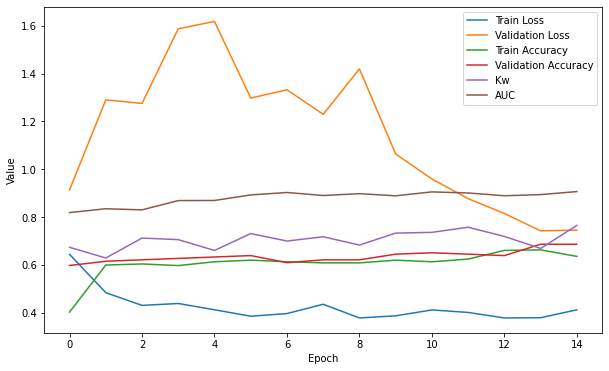

In [91]:
import matplotlib.pyplot as plt

epoch_list = []
train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []
kw_list = []
auc_list = []

for epoch in range(Epochs):
        train_loss, train_acc = train_one_epoch(model=model,
                                                optimizer=optimizer,
                                                data_loader=train_loader,
                                                device=device,
                                                epoch=epoch)
        # validate
        val_loss, val_acc = evaluate(model=model,
                                        data_loader=val_loader,
                                        device=device,
                                        epoch=epoch)
        scheduler.step()
        # 以上循环内三部分写法源于LambdaLR()的torch官方实例
        tags = ["train_loss", "train_acc", "val_loss", "val_acc", "learning_rate"]
        tb_writer.add_scalars('Comparison of train/val acc', {'train_acc':train_acc,
                                        'val_acc':val_acc}, epoch)

        tb_writer.add_scalars('Comparison of train/val loss', {'train':train_loss,
                                        'val':val_loss}, epoch)
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[0], train_loss, epoch)
        tb_writer.add_scalar(tags[1], train_acc, epoch)
        tb_writer.add_scalar(tags[2], val_loss, epoch)
        tb_writer.add_scalar(tags[3], val_acc, epoch)
        tb_writer.add_scalar(tags[4], optimizer.param_groups[0]["lr"], epoch)
        if val_acc>best_acc:
                best_acc=val_acc
                torch.save(model.state_dict(),f'model-{best_acc}.pth')
                name='model-{best_acc}.pth'
        epoch_list.append(epoch)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        val_loss_list.append(val_loss)
        val_acc_list.append(val_acc)

        predict_scores, prediction, true_label = predict_out(model, val_loader, device)
        Kw = quadratic_weighted_kappa(true_label, prediction)
        AUC = roc_auc_score(true_label, predict_scores, average="macro", multi_class='ovo')
        kw_list.append(Kw)
        auc_list.append(AUC)

plt.figure(figsize=(10, 6))
plt.plot(epoch_list, train_loss_list, label='Train Loss')
plt.plot(epoch_list, val_loss_list, label='Validation Loss')
plt.plot(epoch_list, train_acc_list, label='Train Accuracy')
plt.plot(epoch_list, val_acc_list, label='Validation Accuracy')
plt.plot(epoch_list, kw_list, label='Kw')
plt.plot(epoch_list, auc_list, label='AUC')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.savefig('training_graph.png')



In [92]:
predict_scores,prediction,true_label=predict_out(model,val_loader,device)
Kw = quadratic_weighted_kappa(true_label, prediction)
AUC = roc_auc_score(true_label, predict_scores, average="macro", multi_class='ovo')
print(Kw, AUC)

0.7496422025259246 0.8959470888480029


In [94]:
predict_scores2,prediction2,true_label2=predict_out(model,test_loader,device)

test_save_path='./EatAtNight.csv'

dataframe = pandas.DataFrame({'case':test_dataset.x,'class':prediction2,\
                          'P0':predict_scores2[:,0],'P1':predict_scores2[:,1],'P2':predict_scores2[:,2]})
dataframe.to_csv(test_save_path,index=False,sep=',')
# print(dataframe)

         case  class        P0        P1        P2
0     161.png      0  0.939554  0.055074  0.005372
1     268.png      0  0.999164  0.000835  0.000001
2     285.png      1  0.388732  0.467106  0.144162
3     295.png      0  0.702958  0.274681  0.022361
4     298.png      2  0.052505  0.394280  0.553215
..        ...    ...       ...       ...       ...
381  1306.png      0  0.457369  0.313406  0.229225
382  1308.png      0  0.980579  0.018401  0.001019
383  1309.png      2  0.002434  0.106142  0.891424
384  1310.png      0  0.977764  0.021147  0.001089
385  1312.png      1  0.185597  0.629657  0.184745

[386 rows x 5 columns]


In [ ]:

!tensorboard --logdir=/root/tf-logs --port 6007